# Wildfire Cluster Analysis

In [4]:
# Import libraries
import pandas as pd
import geopandas as gpd
import contextily as ctx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
#from sklearn.metrics import silhouette_score
import os

In [5]:
df = pd.read_csv(r"/media/scruffy/Elements/python_data/Final/Prepared_Data/final_data.csv").dropna()

In [6]:
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [7]:
sns.set_theme(rc={'figure.figsize': (8, 12)})

In [8]:
df = df.dropna()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8398500 entries, 2 to 8558834
Data columns (total 27 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   date                               object 
 1   longitude                          float64
 2   latitude                           float64
 3   temperature_2m                     float64
 4   temperature_2m_max                 float64
 5   total_precipitation_sum            float64
 6   dewpoint_temperature_2m            float64
 7   volumetric_soil_water_layer_1      float64
 8   surface_net_solar_radiation_sum    float64
 9   surface_net_thermal_radiation_sum  float64
 10  surface_sensible_heat_flux_sum     float64
 11  potential_evaporation_sum          float64
 12  total_evaporation_sum              float64
 13  leaf_area_index_high_vegetation    float64
 14  leaf_area_index_low_vegetation     float64
 15  max_windspeed                      float64
 16  wind_direction         

In [10]:
df['log_fires'] = np.log1p(df['fires_past_10yrs_count'])
df['log_windspeed'] = np.log1p(df['max_windspeed'])
df['log acres'] = np.log1p(df['active_fire_acres'])

In [11]:
df['point_id'] = df['point_id'].astype('str')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8398500 entries, 2 to 8558834
Data columns (total 30 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   date                               object 
 1   longitude                          float64
 2   latitude                           float64
 3   temperature_2m                     float64
 4   temperature_2m_max                 float64
 5   total_precipitation_sum            float64
 6   dewpoint_temperature_2m            float64
 7   volumetric_soil_water_layer_1      float64
 8   surface_net_solar_radiation_sum    float64
 9   surface_net_thermal_radiation_sum  float64
 10  surface_sensible_heat_flux_sum     float64
 11  potential_evaporation_sum          float64
 12  total_evaporation_sum              float64
 13  leaf_area_index_high_vegetation    float64
 14  leaf_area_index_low_vegetation     float64
 15  max_windspeed                      float64
 16  wind_direction         

In [7]:
full = df.copy()

In [8]:
features = df.drop(columns=['date',
                            'point_id',
                            'longitude',
                            'latitude',
                            'active_fire',
                            'fire_past_5yrs',
                            'active_fire_acres',
                            'fires_past_10yrs_count.1',
                            'fires_past_10yrs_count']
                  ).reset_index(drop=True)

In [10]:
# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [11]:
# PCA for dimensionality reduction
pca = PCA(n_components=5)
pca_features = pca.fit_transform(scaled_features)

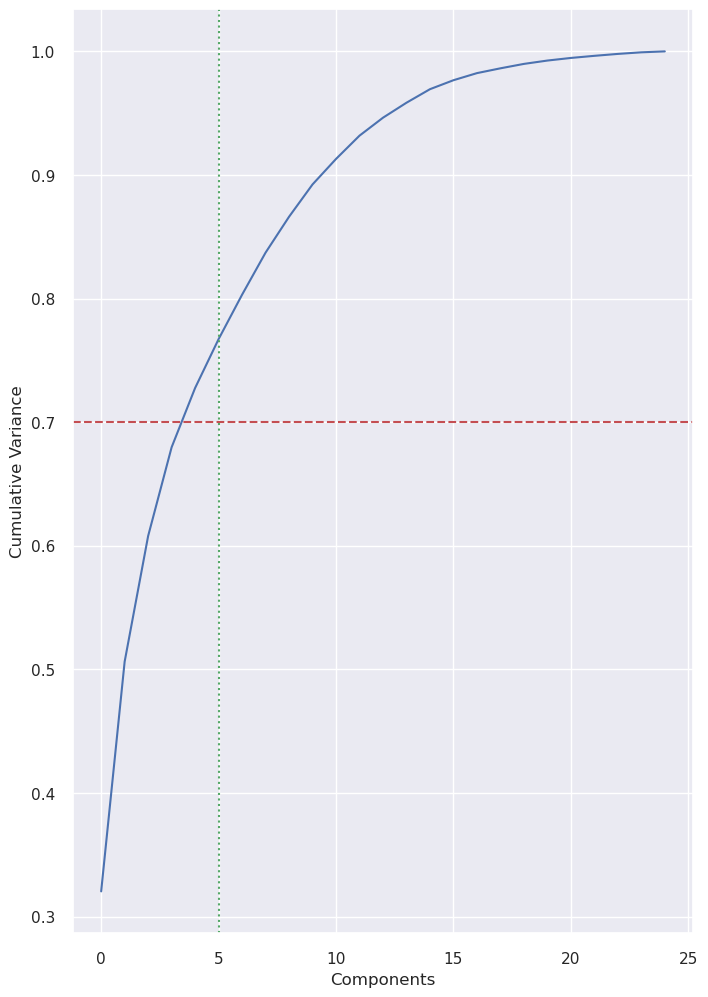

In [24]:
# Variance Explained Analysis
pca_full = PCA().fit(scaled_features)
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('Components')
plt.ylabel('Cumulative Variance')
plt.axhline(0.7, c='r', ls='--')  # 70% variance threshold
plt.axvline(x=5, c='g', ls=':')  # Current n_components

In [25]:
print(f"\nExplained Variance Ratio: {(np.cumsum(pca_full.explained_variance_ratio_)[5]*100).round(2)}%\n")


Explained Variance Ratio: 76.72%



<Axes: >

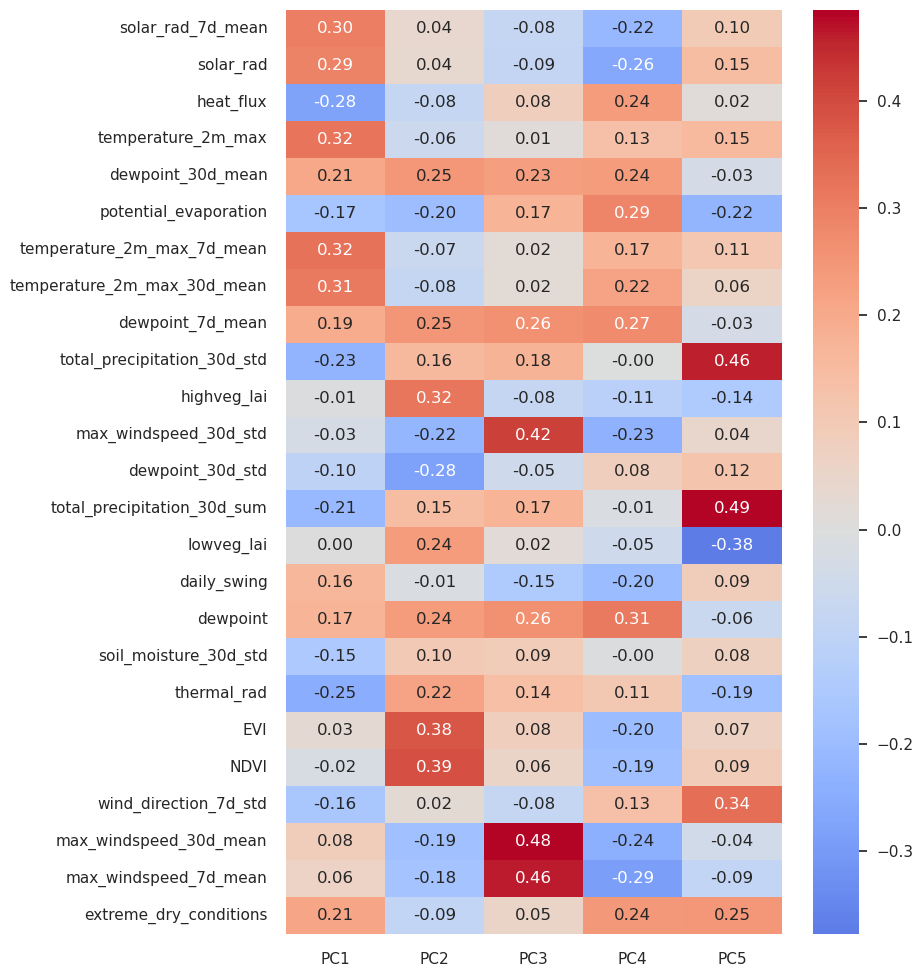

In [12]:
# Loadings Heatmap
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(5)],
    index=features.columns
)
sns.heatmap(loadings, cmap='coolwarm', center=0, annot=True, fmt='.2f')

In [13]:
# Determine optimal clusters
wcss = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_features)
    wcss.append(kmeans.inertia_)

Text(0, 0.5, 'WCSS')

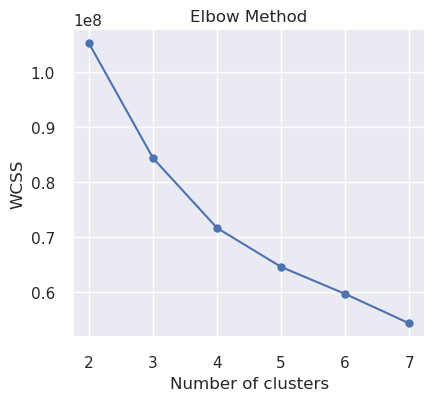

In [28]:
# Plot elbow curve
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(2,8), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [14]:
# Final clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(pca_features)

In [16]:
# Create a DataFrame of scaled features with cluster labels
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
scaled_df['cluster'] = df['cluster']

In [17]:
# Calculate mean scaled values per cluster
scaled_profiles = scaled_df.groupby('cluster').mean().round(2)

In [27]:
clust = df.drop(columns = ['date',
                           'point_id',
                           'longitude',
                           'latitude',
                           'active_fire',
                           'fire_past_5yrs',
                           'active_fire_acres',
                           'fires_past_10yrs_count',
                           'fires_past_10yrs_count.1'])

In [29]:
# Analyze cluster characteristics
cluster_profiles = clust.groupby('cluster').mean().round(2)

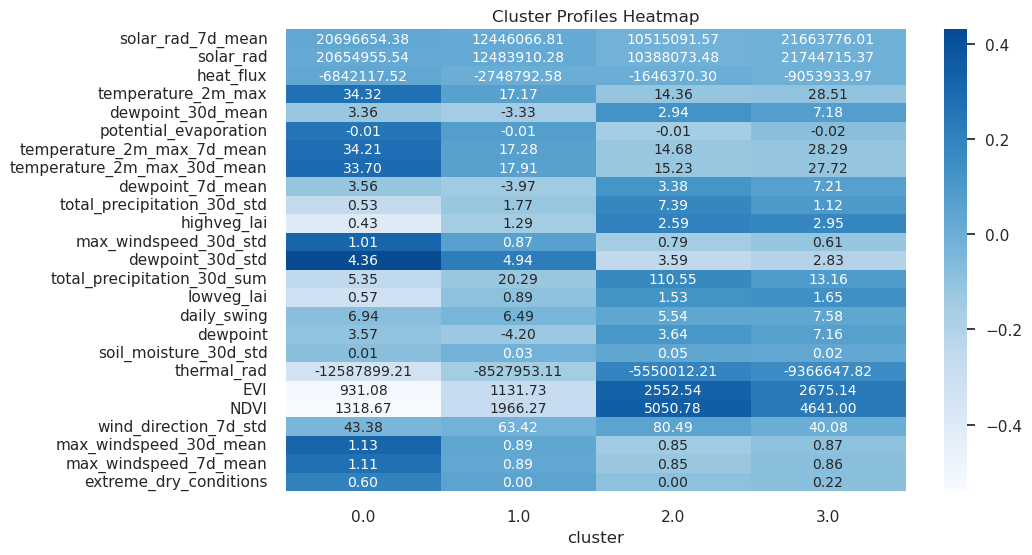

In [45]:
# Visualize profiles
plt.figure(figsize=(10,6))
sns.heatmap(
    scaled_profiles.T,  # Use scaled values for coloring
    annot=cluster_profiles.T,  # Use original values for annotations
    cmap='Blues', 
    fmt='.2f',
    annot_kws={'size': 10},
    center=0  # Center color map at 0 (since data is standardized)
)
plt.title('Cluster Profiles Heatmap')
plt.show()

#### Cluster Description
    Cluster 0 - High heat, high windspeeds, very low vegetation, likely the desert
    Cluster 1 - High change in humidity, high preciptation, moderate temps, moderate vegetation - likely springtime
    Cluster 2 - Very high vegetation, high 30 day rainfall, low temps, high humidity, likely the forest
    Cluster 3 - Very high vegetation, low rainfall, moderate temps, low wind divergence, forest in winter?

In [46]:
# Compare cluster sizes
print(df['cluster'].value_counts().sort_index())

cluster
0    1473305
1    2049908
2    2066756
3    2868823
Name: count, dtype: int64


In [63]:
test_date = df[df['date']=='2019-12-15']

In [68]:
# Create point geometries
geometry = gpd.points_from_xy(test_date['longitude'], test_date['latitude'])
# Create GeoDataFrame
gdf = gpd.GeoDataFrame(test_date, geometry=geometry, crs="EPSG:4326")

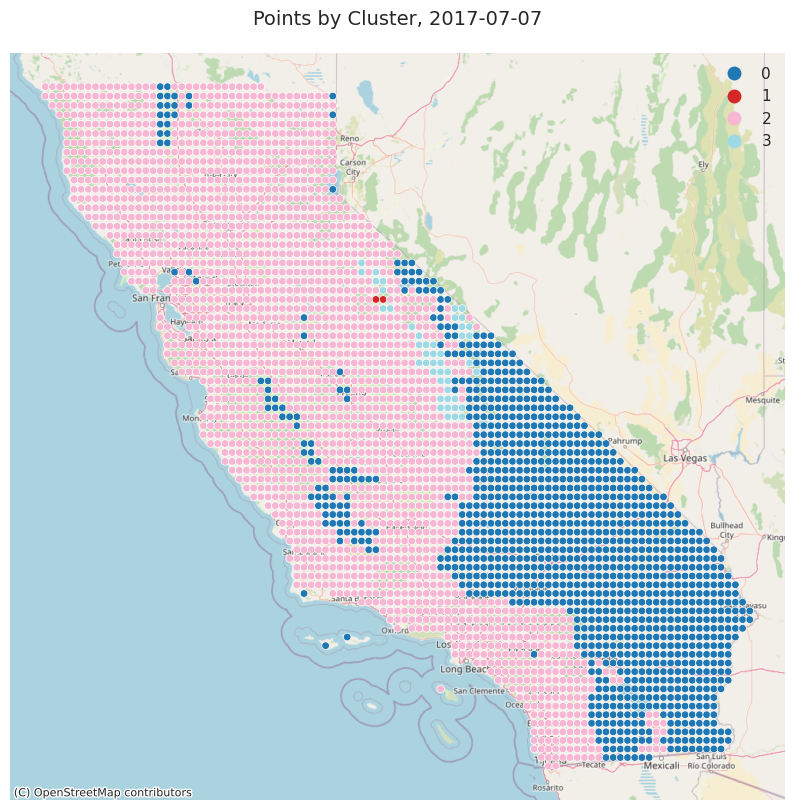

In [55]:
# Create qualitative colormap
cmap = plt.get_cmap('tab20', 4)

# Plot with discrete colors
ax = gdf.plot(
    figsize=(10, 10),
    column='cluster',
    categorical=True,
    cmap=cmap,
    legend=True,
    markersize=30,
    alpha=1,
    edgecolor='white',
    linewidth=0.5
)

# Add basemap and style
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title('Points by Cluster, 2017-07-07', fontsize=14, pad=20)

plt.show()

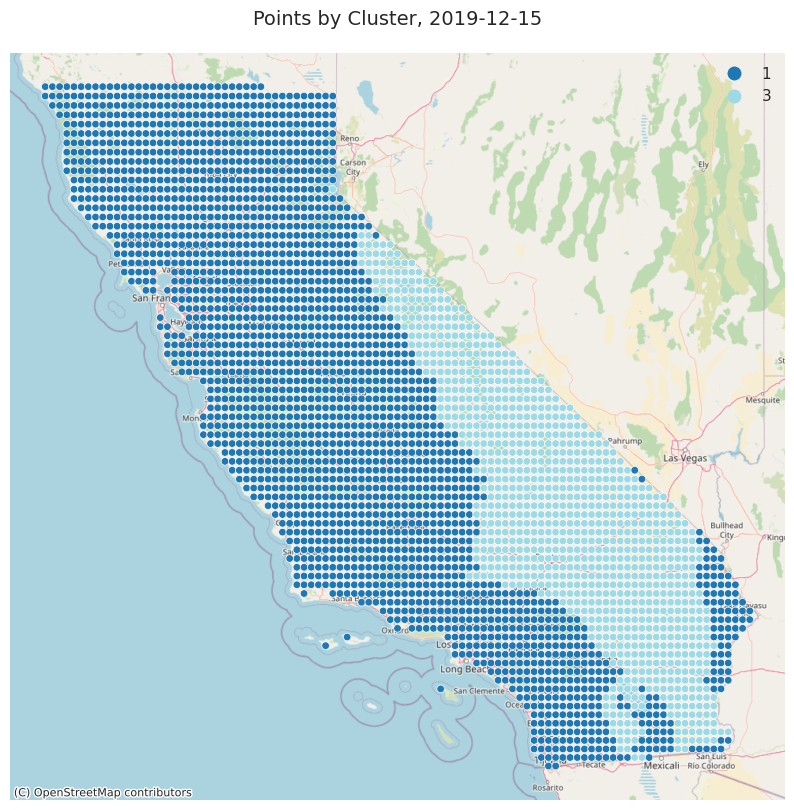

In [71]:
gdf = gdf.to_crs(epsg=3857)

# Create qualitative colormap
cmap = plt.get_cmap('tab20', 4)

# Plot with discrete colors
ax = gdf.plot(
    figsize=(10, 10),
    column='cluster',
    categorical=True,
    cmap=cmap,
    legend=True,
    markersize=30,
    alpha=1,
    edgecolor='white',
    linewidth=0.5
)

# Add basemap and style
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title('Points by Cluster, 2019-12-15', fontsize=14, pad=20)

plt.show()

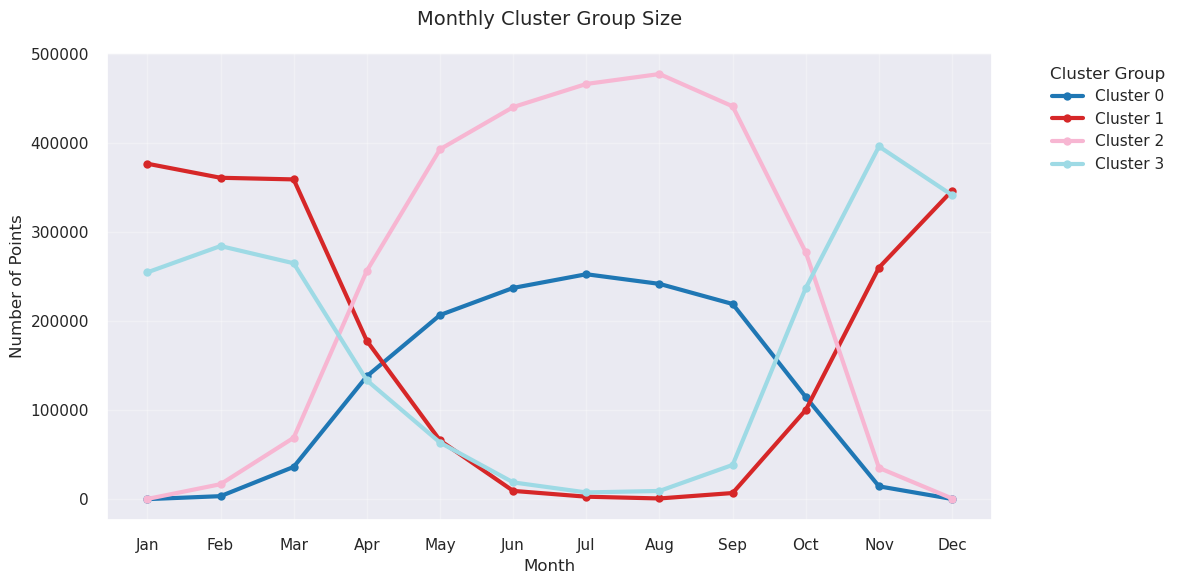

In [62]:
# Ensure date is datetime and extract month
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month

# Count points per cluster per month
cluster_counts = df.groupby(['month', 'cluster']).size().unstack()

cmap = plt.get_cmap('tab20', 4)

# Create plot
plt.figure(figsize=(12, 6))

# Plot each cluster's trend
for i, cluster in enumerate(cluster_counts.columns):
    plt.plot(cluster_counts.index, 
             cluster_counts[cluster], 
             label=f'Cluster {cluster}',
             color=cmap(i),
             linewidth=3,
             marker='o')

# Style the plot
plt.title('Monthly Cluster Group Size', fontsize=14, pad=20)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Points', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(alpha=0.3)
plt.legend(title='Cluster Group', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

    Cluster 0 - Desert Spring-Fall
    Cluster 1 - Forest/Coast Winter/Spring
    Cluster 2 - Forest/Coast Summer
    Cluster 3 - Desert/Mountains Winter

In [50]:
df.groupby('cluster')['active_fire'].mean()

cluster
0    0.000237
1    0.000106
2    0.001729
3    0.000181
Name: active_fire, dtype: float64

In [51]:
df.groupby('cluster')['active_fire_acres'].mean()

cluster
0     1.759994
1     1.048949
2    76.372073
3     3.214804
Name: active_fire_acres, dtype: float64

### Discussion
    Ultimately this doesn't tell us much that we didn't know. Forest fires are likeliest in forests when it's hot.
    There are powerful spatial and temporal biases in our data.
    We need to control for trends, seasonality, and spatial autocorrelation before being able to derive useful insights.